<a href="https://colab.research.google.com/github/gc2321/3235-Machine-Learning/blob/main/XTRA_NEURO_NET_EXERCISES/3_rnn_frozen_dessert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(42)

In [6]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

import fileinput
filePath ="/content/gdrive/MyDrive/neural_data/RSCCASN.csv"

import pandas as pd
df = pd.read_csv(filePath,index_col='DATE',parse_dates=True)

df.head(3)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [8]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

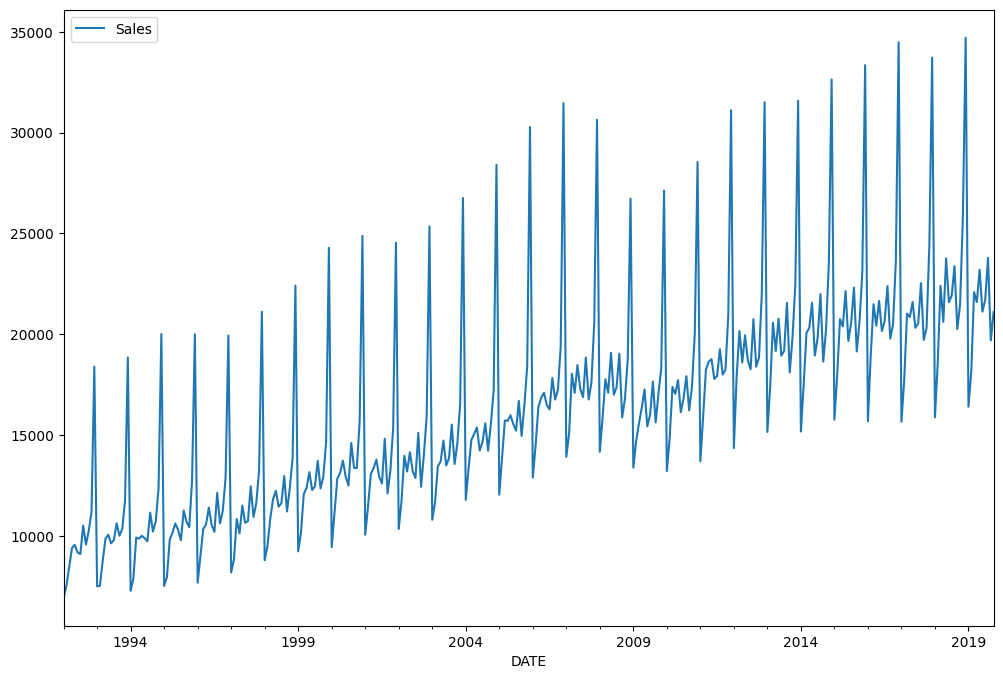

In [9]:
df.plot(figsize=(12,8))

## Train Test Split

In [10]:
# data is monthly, do forest for 1.5 years into the future
len(df)- 18


316

In [11]:
test_size = 18

In [12]:
test_ind = len(df)- test_size

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
train.head(3)

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475


In [15]:
test.head(3)

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


## Scale Data

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [17]:
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12 # test length is 18, need to use a value less than 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [23]:
# What does the first batch look like?
X,y = generator[0]

In [24]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Create the Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
# We're only using one feature in our time series
n_features = 1

In [27]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [30]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [31]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


<ipython-input-31-3878a3328f67>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 4s 9ms/step - loss: 0.0247 - val_loss: 0.0081
Epoch 2/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0171 - val_loss: 0.0067
Epoch 3/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0098 - val_loss: 0.0030
Epoch 4/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 5/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0027 - val_loss: 5.5493e-04
Epoch 6/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0027 - val_loss: 6.3199e-04
Epoch 7/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0016 - val_loss: 0.0021


In [32]:
losses = pd.DataFrame(model.history.history)

<Axes: >

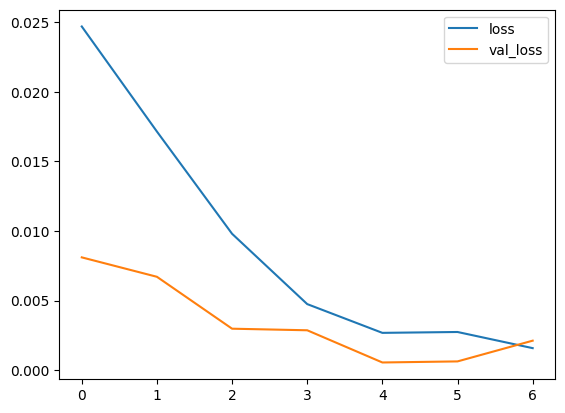

In [33]:
losses.plot()

## Evaluate on Test Data

In [35]:
first_eval_batch = scaled_train[-length:]

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test['Predictions'] = true_predictions

<ipython-input-38-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [39]:
test.head(5)

,Sales,Predictions
DATE,,
2018-05-01,23764,22385.281445
2018-06-01,21589,21362.710681
2018-07-01,21919,21590.332798
2018-08-01,23381,23237.003459
2018-09-01,20260,20998.923433


<Axes: xlabel='DATE'>

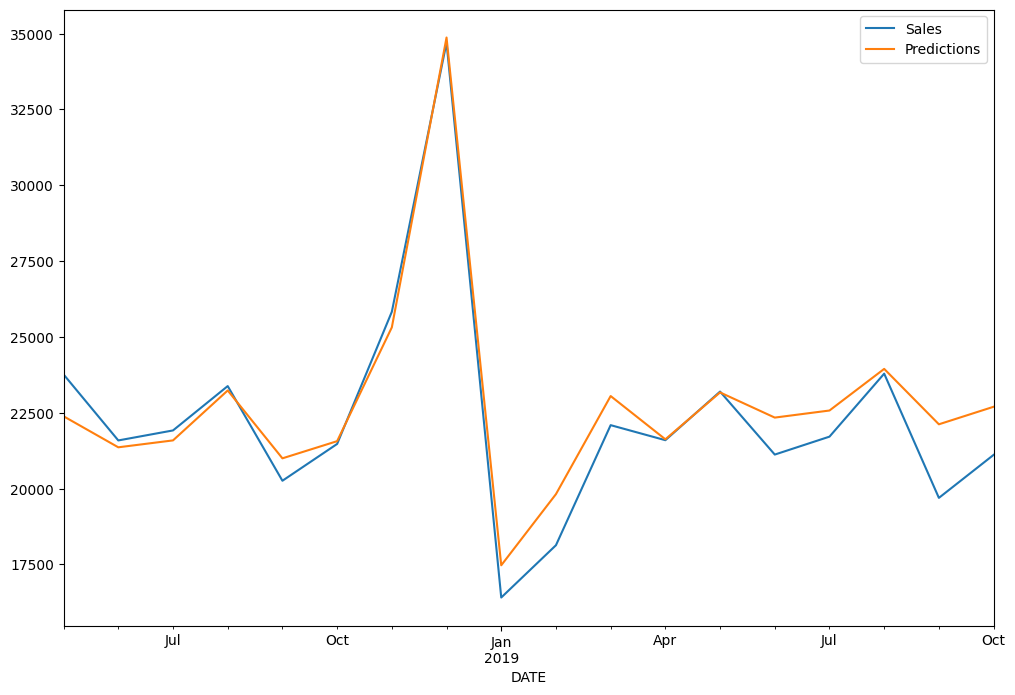

In [40]:
test.plot(figsize=(12,8))

## Retrain and Forecasting

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [43]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


<ipython-input-43-74a9761509e5>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


322/322 [==============================] - 5s 12ms/step - loss: 0.0270
Epoch 2/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0193
Epoch 3/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0132
Epoch 4/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0057
Epoch 5/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0045
Epoch 6/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0030
Epoch 7/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0015
Epoch 8/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0015


In [44]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 63ms/step


In [45]:
forecast = scaler.inverse_transform(forecast)

## Creating new timestamp index with Pandas

In [46]:
df.head(5)

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [47]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [48]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [49]:
forecast_df.head(5)


,Forecast
2019-11-01,25858.758898
2019-12-01,35653.635127
2020-01-01,17928.494866
2020-02-01,19339.410179
2020-03-01,22273.397801


<Axes: >

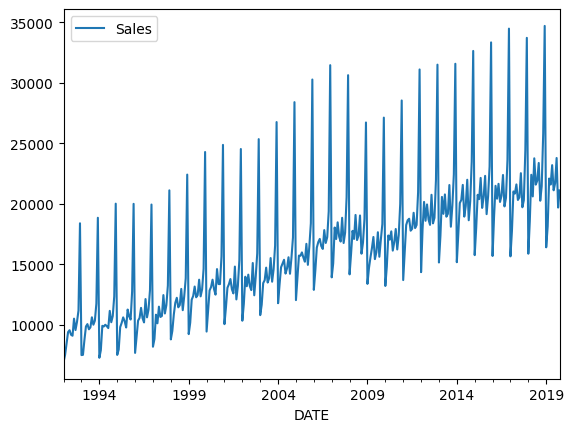

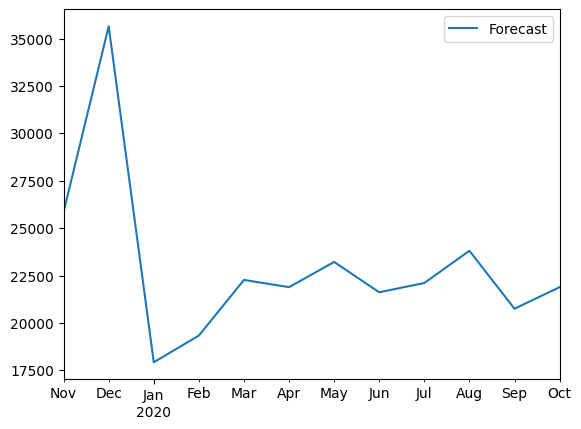

In [50]:
df.plot()
forecast_df.plot()

<Axes: xlabel='DATE'>

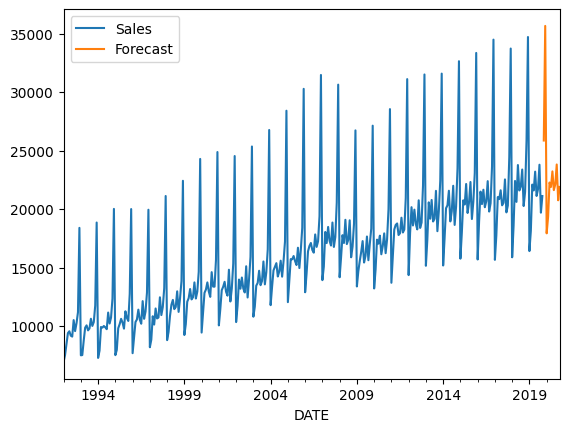

In [53]:
## Joining Pandas plot
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

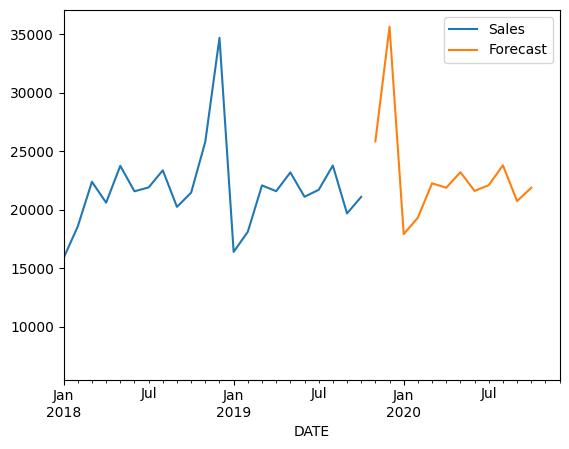

In [54]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')